| Index | Input features                               | Num basis | Best regularizer  | Train loss         | Val loss           | Trained on Train+Val, Test loss |
|-------|----------------------------------------------|-----------|-------------------|--------------------|--------------------|---------------------------------|
| 1     | $p$, $U:2$                                   | 30        | 918.3673469387755 | 80.07083330109923  | 72.88830499581941  | 34.77367125907225               |
| 2     | $p$, $U:0$, $U:1$, $U:2$                     | 30        | 787.7551020408164 | 31.433791911673303 | 10.163383880377792 | 76.88117184154255               |
| 3     | $p$, $U:0$, $U:1$, $U:2$, $k$                | 30        | 983.6734693877552 | 67.12018047282386  | 12.582043643474162 | 104.36366999834868              |
| 4     | $p$, $U:0$, $U:1$, $U:2$, $k$, $\omega$      | 30        | 885.7142857142858 | 70.41700248056551  | 17.99203824366539  | 103.55583118578296              |
| 5     | $p$, $U:0$, $U:1$, $U:2$, $k$, nut, $\omega$ | 30        | 2041734.693877551 | 87.14441862549879  | 21.861644767314626 | 85.7531373126712                |


<!---|Index | Input features                              | Num basis | Regularizer range 1 | Regularizer range 2 | Best regularizer       | Train loss         | Val loss           | Trained on Train+Val, Test loss |  Past test loss  | Remark
|-|-------------------------------------|-----------|-------------------|--------------------|--------------------|---------------------------------|---|  ----|--|--|
|1| $p$, $U:2$  | 15      | np.linspace(1e3, 5e4), 15) | np.linspace(3e3, 5e3)  | 4183.673469387755 | 168.73394113815039 | 201.71884028821677 | 137.14877428798286     | 455.61986895953567   478.81477974255034    483.8987597939727  | For val and test, means of prediction is around 0
|2| $p$, $U:0$, $U:1$, $U:2$                    | 30        |  np.linspace(1e3, 25e6) |       |    25408.163265306124      |    130.31972427087229 | 209.91278784091764                                  |                         134.77216040540588        |  | For val, means of prediction is not around 0 but like a sine wave, for test a linear line  |
|3| $p$, $U:0$, $U:1$, $U:2$, $k$               |       30    |     |     |  29795.918367346938     |       142.55651457221143 | 203.17652056142774             | 129.17988306070532                                               |  |  |
|4| $p$, $U:0$, $U:1$, $U:2$, $k$, $\omega$      |   30        |       |   |    33877.551020408166    |      153.94629821014348 | 201.5985912259407              |                                129.93413070964195       |  | For val, the sine wave has an upward direction. For test, a straight line with upward direction  |
|5| $p$, $U:0$, $U:1$, $U:2$, $k$, nut, $\omega$ |           |          | |       |                    |                    |                                 |  |  |



In [1]:
import rom_operator_inference as opinf

import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools

from tqdm.notebook import tqdm
import warnings
from scipy.integrate import IntegrationWarning
from scipy.linalg import LinAlgWarning

In [2]:
# !pip install git+https://github.com/Willcox-Research-Group/rom-operator-inference-Python3.git

In [3]:
# Matplotlib customizations.
plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("font", family="serif", size=6)
plt.rc("legend", edgecolor='none')

In [4]:
chosen_columns = ['p', 'U:2',]  # check absolute value other U:0, U:1 (done in 01_data_transform.ipynb)
sets = ['train', 'val', 'test']

input_files = [(dataset, column) for dataset in sets for column in chosen_columns]

In [5]:
input_files

[('train', 'p'),
 ('train', 'U:2'),
 ('val', 'p'),
 ('val', 'U:2'),
 ('test', 'p'),
 ('test', 'U:2')]

In [6]:
tables = {}
for i in input_files:
    with open(f'{i[0]}_{i[1]}.pkl', 'rb') as f:        
        tables[f'{i[0]}_{i[1]}'] = pickle.load(f)

## Plotting the mean pressure and speed

In [7]:
tables['train_p']

array([[ 1.4445e+03,  1.4678e+03,  9.1165e+02, ...,  1.8920e+01,
         6.8789e+02,  5.4110e+01],
       [ 5.6425e+01,  5.6638e+01,  3.5030e+01, ...,  1.9281e-01,
         2.6116e+01,  1.3049e-01],
       [ 4.2710e+01,  4.2920e+01,  2.6186e+01, ...,  1.8577e-01,
         1.9372e+01,  1.1555e-01],
       ...,
       [ 4.7090e+01,  4.6317e+01,  1.7447e+01, ..., -7.0256e-01,
         1.4649e+01, -6.0105e+00],
       [ 4.3804e+01,  4.3018e+01,  1.6618e+01, ..., -7.0879e-01,
         1.4163e+01, -5.8979e+00],
       [ 4.0023e+01,  3.9226e+01,  1.5513e+01, ..., -7.0813e-01,
         1.3368e+01, -5.8251e+00]])

In [8]:
tables['train_p'].shape
# check if mean is dominant, plot eigen values and eigen vectors of the PCA.
# Plot eigen values see if decrease
# OR plot the sum of eigen values
# if increase the number of eigen values, "energy" is increase s.t we perserve the system
# cumulative e. preservation Sum of eigen / sum of all of eigen
# done, see below

(499, 7582)

In [9]:
DELTA_T = 2e-3 # step of a time
MAX_T = 2

According to the https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/main/docs/content/tutorials/basics.ipynb, the matrix must be `space` $\times$ `time`

In [10]:
for t in tables:
    tables[t] = tables[t].T

In [11]:
assert tables['train_p'].shape[0] > tables['train_p'].shape[1]   # space is larger than time

In [12]:
all_pressures = np.concatenate([tables['train_p'], tables['val_p'], tables['test_p']],axis=1)
all_pressures.shape

(7582, 999)

In [13]:
all_pressures_mean = all_pressures.mean(0)

In [14]:
tables['train_p'].shape

(7582, 499)

In [15]:
all_pressures_mean.shape

(999,)

## Load boundary condition

In [16]:
v_inlet_bc = pd.read_csv('inlet_df.csv')

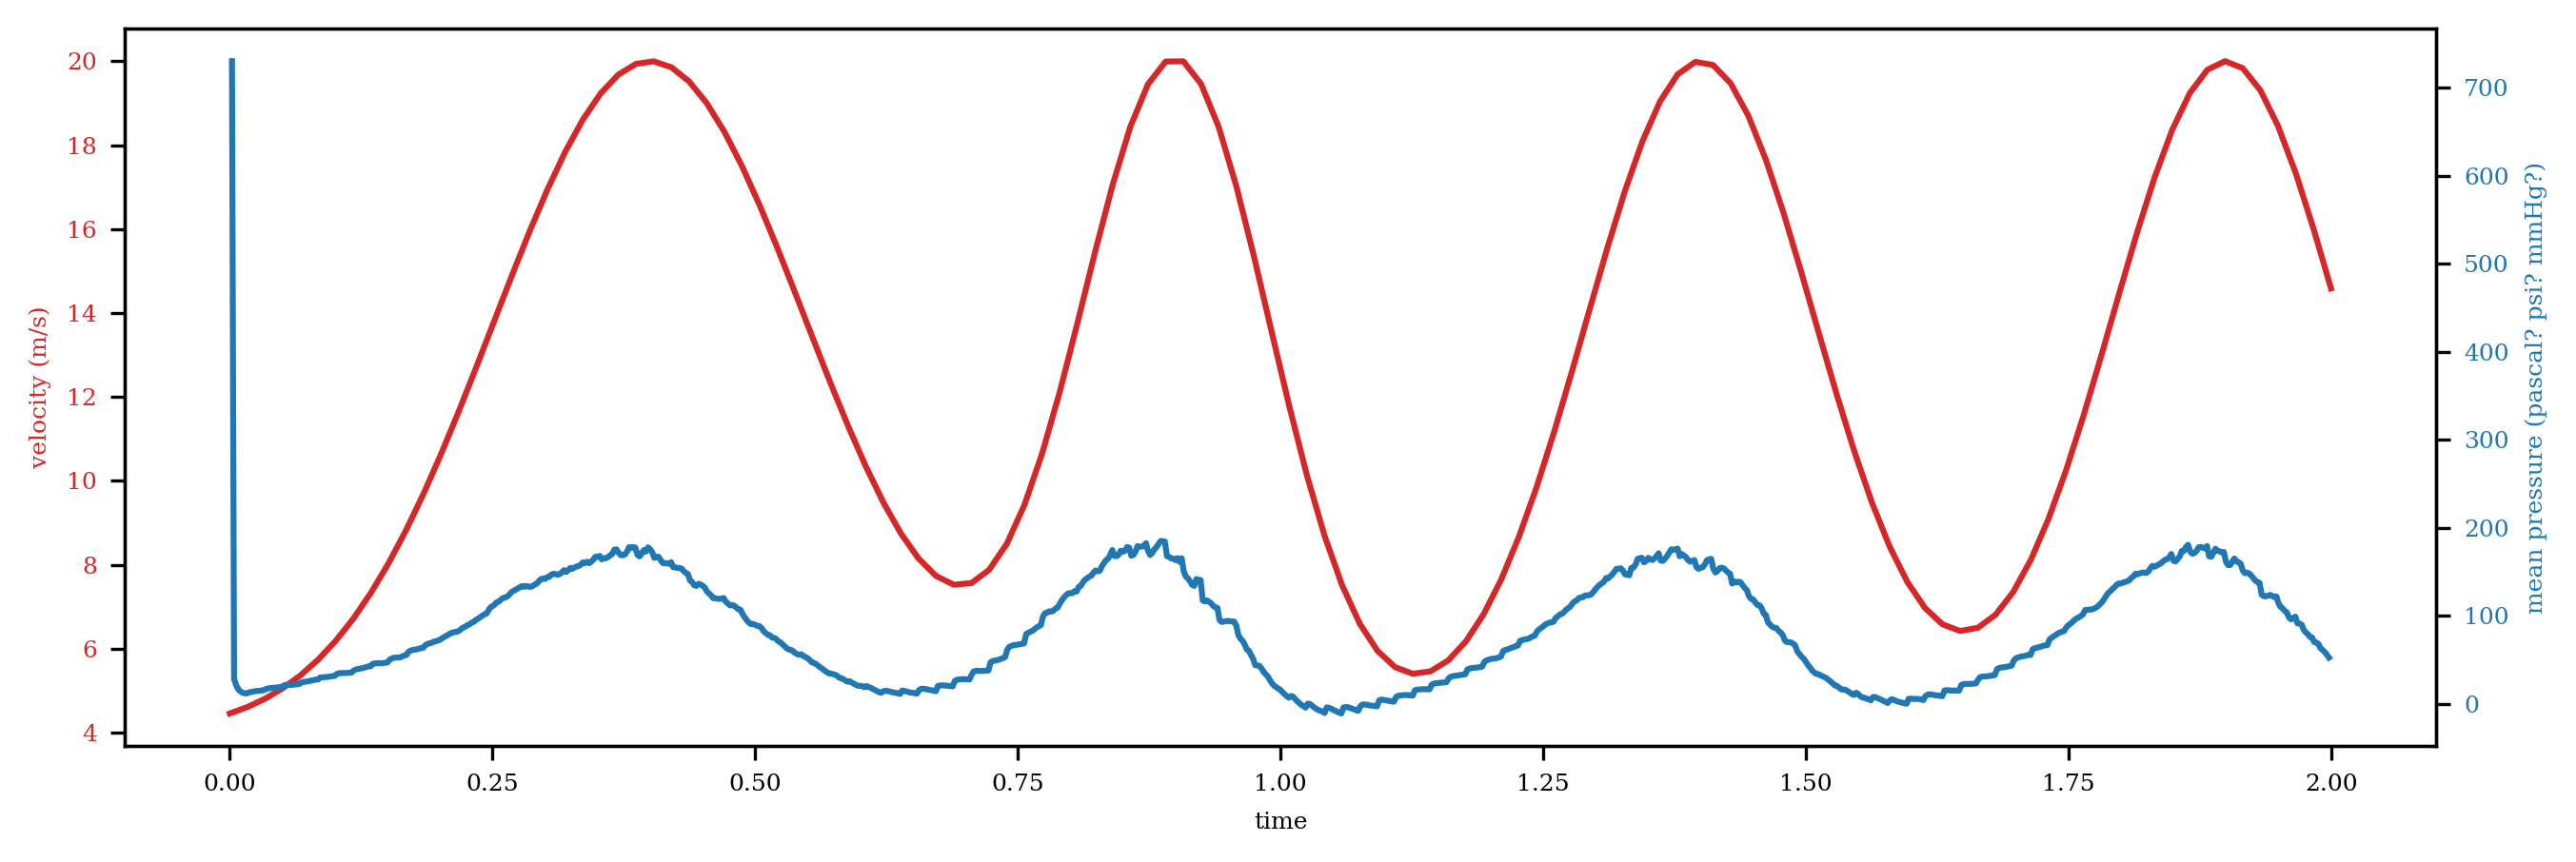

In [17]:
fig, ax1 = plt.subplots()
x1 = np.arange(DELTA_T, MAX_T, DELTA_T)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('velocity (m/s)', color=color)
ax1.plot(v_inlet_bc['t'], v_inlet_bc['Uz'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('mean pressure (pascal? psi? mmHg?)', color=color)
ax2.plot(x1, all_pressures_mean)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# todo ignore the 1st step of data

# for future, BC as a forcing term

Due to the strange outlier in 1st frame of pressure, we will ignore it

In [18]:
# discard the first data point for train
for i in chosen_columns:
    tables[f'train_{i}'] = tables[f'train_{i}'][:,1:]

## Scale and stack data

Scale separately for each feature, s.t they have 0 mean, 1 std. Then stacking `[rho_0, v_0, rho_1, v_1, … , rho_n, v_n]` to a `train_data`. The shape would be (`space` $\times$ `num_ft`, `time`)

$
\begin{bmatrix} p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
p_{m,1} & p_{m,2} & \cdots & p_{m,n} \end{bmatrix}
$
$
\begin{bmatrix} U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ 
U:2_{2,1} & U:2_{2,2} & \cdots & U:2_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}
$
$
\rightarrow
$
$
\begin{bmatrix} k_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ nut_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ \omega_{1,1} & \omega_{1,2} & \cdots & \omega_{1,n} \\  p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\  U:0_{1,1} & U:0_{1,2} & \cdots & U:0_{1,n} \\  U:1_{1,1} & U:1_{1,2} & \cdots & U:1_{1,n} \\  U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ \vdots & \vdots & \vdots & \vdots \\ U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}  (1)
$

with $m$ is space and $n$ is time (https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/issues/30)

### Normalize data

In [19]:
def normalize(timeframes, max_ft = None, min_ft = None):
    '''
    At t=0, get the mean and std through spacial dimension
    '''
    if max_ft is not None and min_ft is not None:
        scaled = (timeframes - min_ft) / (max_ft - min_ft)
        return scaled
    max_ft = timeframes.max(1).reshape((timeframes.shape[0], 1))
    min_ft = timeframes.min(1).reshape((timeframes.shape[0], 1))
    for i in range(max_ft.shape[0]):
        if max_ft[i] == min_ft[i]:
            max_ft[i] += 1  # so that (x - min_ft[i]) / (max_ft[i] - min_ft[i]) = (x - min_ft[i]) / 1, to avoid div by 0
    scaled = (timeframes - min_ft) / (max_ft - min_ft)
    return scaled, max_ft, min_ft

In [20]:
# test normalize
data = np.array([[-1. ,  2. ], [-0.5,  6. ], [ 0. , 10. ], [ 1. , 18. ]])
normed_data, max_ft, min_ft = normalize(data)
print(f"{max_ft} \n {min_ft} \n {normed_data}")
print(normalize([[100], [100], [100], [100]], max_ft, min_ft))

[[ 2.]
 [ 6.]
 [10.]
 [18.]] 
 [[-1. ]
 [-0.5]
 [ 0. ]
 [ 1. ]] 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[33.66666667]
 [15.46153846]
 [10.        ]
 [ 5.82352941]]


In [21]:
normed_data, max_ft, min_ft = {}, {}, {}
for key in tables:
    if key.startswith('train'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])

### Stack data

In [22]:
def stack_data(tables_to_stack, set_name):
    if set_name not in('train', 'val', 'test', 'train_val'):
        raise ValueError
    data = []
    for row in range(tables_to_stack[f'{set_name}_p'].shape[0]):
        for i in tables_to_stack:
            if i.startswith(set_name):
                data.append(tables_to_stack[i][row])
    data = np.array(data)
    print("After stacking shape: ", data.shape)
    assert len(data) == sum([len(tables_to_stack[t]) for t in tables_to_stack if t.startswith(set_name)])  # train_data long as concat of all tables
    return data

In [23]:
# test stack_data
# tr_p_11: train p at space 1 time 1
test_table = {'train_p': np.array([['tr_p_11', 'tr_p_12'], ['tr_p_21', 'tr_p_22']]), 
              'train_u': np.array([['tr_u_11', 'tr_u_12'], ['tr_u_21', 'tr_u_22']]),
              'val_p': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']]), 
              'val_u': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']])}
expected_result = np.array([['tr_p_11', 'tr_p_12'], ['tr_u_11', 'tr_u_12'], 
                            ['tr_p_21', 'tr_p_22'], ['tr_u_21', 'tr_u_22']])
assert (stack_data(test_table, 'train') == expected_result).all()
expected_result

After stacking shape:  (4, 2)


array([['tr_p_11', 'tr_p_12'],
       ['tr_u_11', 'tr_u_12'],
       ['tr_p_21', 'tr_p_22'],
       ['tr_u_21', 'tr_u_22']], dtype='<U7')

In [24]:
def unstack_data(array, ft, list_of_fts):
    # find the order $o$ of `ft` in `list_of_fts`
    # then extract every $o$th row, starting from the first $o$th row, not 0
    assert len(array.shape) == 2
    index = list_of_fts.index(ft)
    return array[np.arange(index, array.shape[0], len(list_of_fts)),:]

In [25]:
test_arr = np.array([['u11', 'u12', 'u13'], ['v11', 'v12', 'v13'], ['p11', 'p12', 'p13'], 
                     ['u21', 'u22', 'u23'], ['v21', 'v22', 'v23'], ['p21', 'p22', 'p23']])
assert (unstack_data(test_arr, 'u', ['u', 'v', 'p']) == np.array([['u11', 'u12', 'u13'], ['u21', 'u22', 'u23']])).all()  # a: 1st element, sample every 1
assert (unstack_data(test_arr, 'v', ['u', 'v', 'p']) == np.array([['v11', 'v12', 'v13'], ['v21', 'v22', 'v23']])).all()  # b: 2nd element, sample every 2
assert (unstack_data(test_arr, 'p', ['u', 'v', 'p']) == np.array([['p11', 'p12', 'p13'], ['p21', 'p22', 'p23']])).all()  # c: 3rd element, sample every 3

In [26]:
# interpolation of BC
inlet_function = np.interp(np.arange(0, 2, DELTA_T), xp=v_inlet_bc['t'].values, fp=v_inlet_bc['Uz'].values)

In [27]:
def prepare_data_and_train(data_to_train, r, regularizer=1e6):
    train_data_derivative = opinf.pre.ddt(data_to_train, DELTA_T, order=6)        # Calculate the time derivative matrix.
    Vr, _ = opinf.pre.pod_basis(data_to_train, r)
    model_form = "cAHB"
    print(f"Model form: {model_form}")
    # todo add quadratics cA is just DMD https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/dad3b6588708c2a4d600491ebd936165a76968ca/src/rom_operator_inference/core/nonparametric/_public.py#L217
    rom = opinf.ContinuousOpInfROM(modelform=model_form)
    rom.fit(Vr, data_to_train, train_data_derivative, regularizer=regularizer, inputs=inlet_function[:data_to_train.shape[1]])
    return rom

In [28]:
def post_process(prediction, max_ft, min_ft):
    scaled_predicted_p = unstack_data(prediction, 'p', chosen_columns)
    predicted_p = (scaled_predicted_p * (max_ft - min_ft)) + min_ft
    return predicted_p

### Create train data

In [29]:
# stack data
train_data = stack_data(normed_data, 'train')
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()

for i, column_name in enumerate(chosen_columns):
    assert (train_data[i,:] == normed_data[f'train_{column_name}'][0,:]).all()

After stacking shape:  (15164, 498)


In [30]:
start_prediction = (tables['train_p'].shape[1] + 1 + 1) * DELTA_T  # 1 for skipping one at the beginning, 1 for the frame after last frame
end_prediction = (tables['train_p'].shape[1] + tables['val_p'].shape[1] + 1 + 1) * DELTA_T
print(start_prediction, end_prediction)

1.0 1.198


## Choosing number of basis

### Exploration

In [31]:
import scipy.linalg as la

svdvals = la.svdvals(train_data)

498

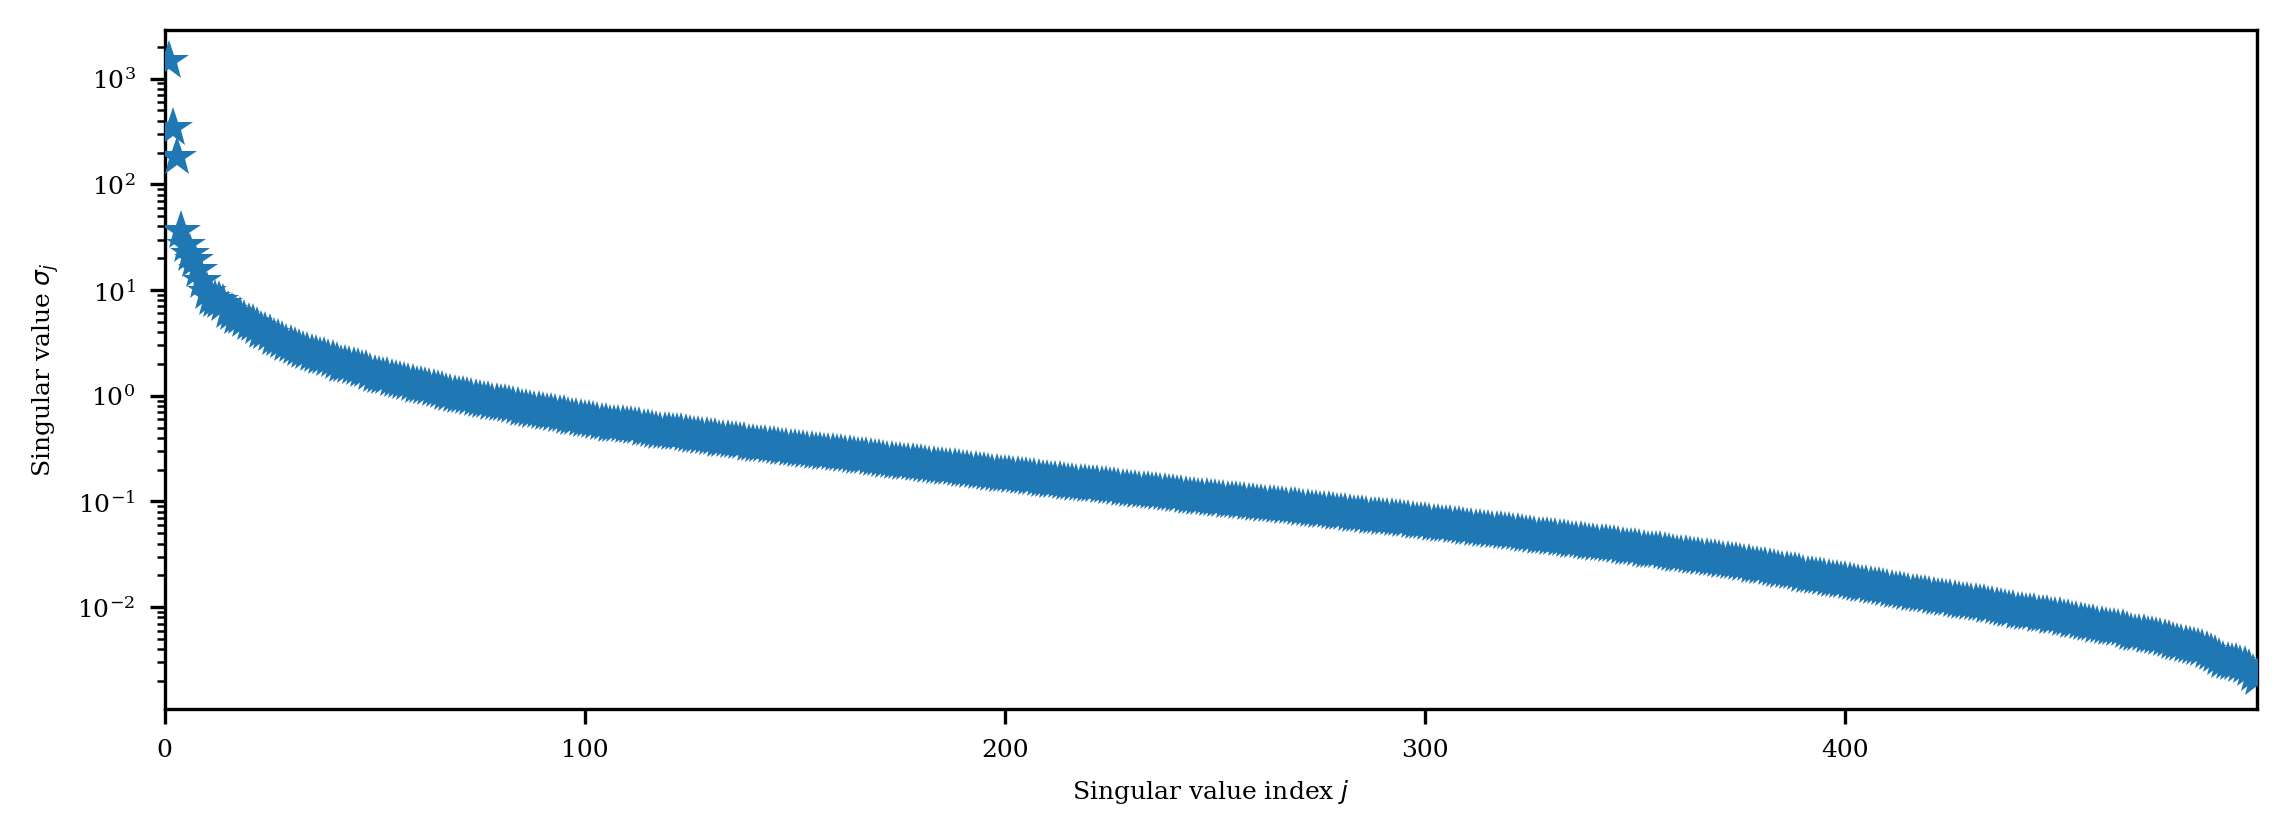

In [32]:
opinf.pre.svdval_decay(svdvals, 1e-3, plot=True)

In [33]:
r = opinf.pre.cumulative_energy(svdvals, .99, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .995, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .999, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9996, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9999, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .99894, plot=False)
print(f"r = {r}")

r = 3
r = 3
r = 5
r = 9
r = 24
r = 5


| Input features                              | Num basis | Range of "safe" basis |
|---------------------------------------------|-----------|-----------------------|
| $p$, $U:2$                                  | 15        |          ?             |
| $p$, $U:0$, $U:1$, $U:2$                    | 30          | ? - 30 (More: Underdetermined linear system /rom_operator_inference/lstsq/_tikhonov.py:178)                |
| $p$, $U:0$, $U:1$, $U:2$, $k$               | 30          | ?-30                      |
| $p$, $U:0$, $U:1$, $U:2$, $k$, $omega$      |           |                       |
| $p$, $U:0$, $U:1$, $U:2$, $k$, nut, $omega$ |           |                       |

`om_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)`

In [34]:
r = 30
Vr, _ = opinf.pre.pod_basis(train_data, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (15164, 30)


In [35]:
assert 2==1

AssertionError: 

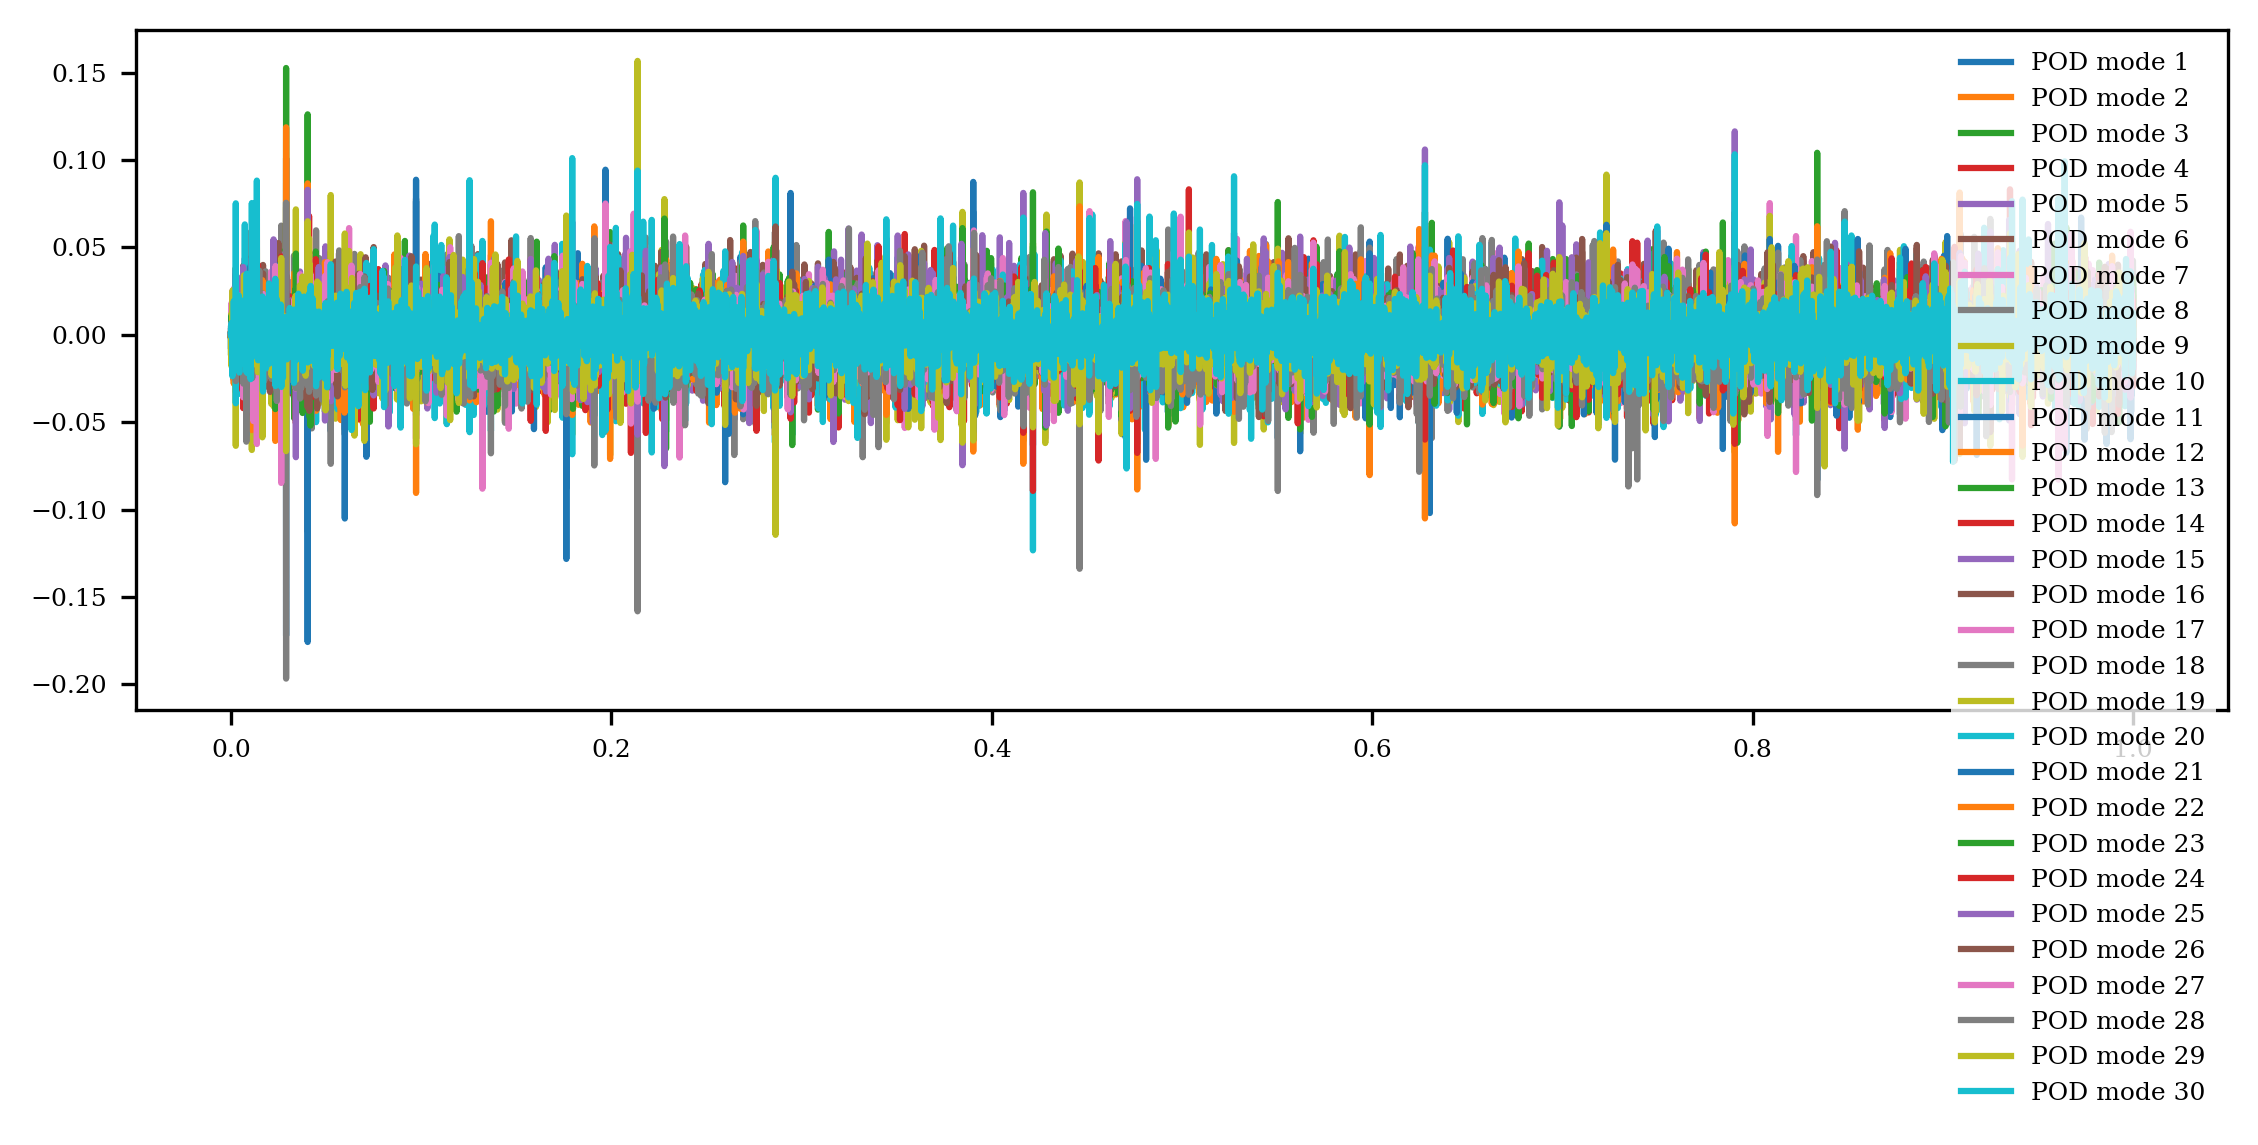

In [36]:
# Visualize those pod
for j in range(Vr.shape[1]):    
    plt.plot(np.linspace(0, 1, Vr.shape[0]+2), np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()

### Test number of basis

In [37]:
# on train
pca = PCA(n_components=r).fit(train_data)
reduced_data = pca.transform(train_data)
reconstructed_data = pca.inverse_transform(reduced_data)
print("Train reconstruction loss: ", mse(reconstructed_data, train_data))

# on test, with same r, should have similar loss, to make sure there is no distribution shift
for key in tables:
    if key.startswith('test'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])
test_data = stack_data(normed_data, 'test')
pca_test = PCA(n_components=r).fit(test_data)
reduced_data = pca_test.transform(test_data)
reconstructed_data = pca_test.inverse_transform(reduced_data)
print("Test reconstruction loss: ", mse(reconstructed_data, test_data))

Train reconstruction loss:  2.1194774880429418e-05
After stacking shape:  (15164, 401)
Test reconstruction loss:  2.2580493625488216e-05


No big difference in test and train data, with same `r`

## Train, test on val

In [38]:
def train_and_plot(regularizer_range, r):
    regularizers, val_losses, train_losses = [], [], []
    for regularizer in tqdm(regularizer_range):
        rom = prepare_data_and_train(train_data, r=r, regularizer=regularizer)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                prediction = rom.predict(train_data[:,-1], 
                                         np.arange(start_prediction, end_prediction, DELTA_T), 
                                         method='Radau',
                                         input_func=inlet_function[train_data.shape[1]:train_data.shape[1]+tables['val_p'].shape[1]]
                                        )   # predict from the last column of train data        
                # prediction is for multiple variable in chosen_colums. We only care about `p`. 
                # Therefore we are going to extract p from it
                predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
                val_loss = mse(predicted_p , tables['val_p'], squared=False)   
                sanity_check = rom.predict(train_data[:,0], 
                                           np.arange(DELTA_T, start_prediction- DELTA_T, DELTA_T), 
                                           method='Radau',
                                           input_func=inlet_function[:train_data.shape[1]]
                                          )
                sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])
                train_loss = mse(sanity_check , tables['train_p'], squared=False)
                print(regularizer, train_loss, val_loss)
                regularizers.append(regularizer)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
            except IntegrationWarning:
                print(f'regularizer={regularizer}, integration error happens')                
            except LinAlgWarning:
                print(f'regularizer={regularizer}, unterdetermined system')
    return regularizers, train_losses, val_losses

In [39]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(1e3, 25e6), r=190)

  0%|          | 0/50 [00:00<?, ?it/s]

Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


1000.0 52.77211277473375 71.90657218958623
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


511183.67346938775 87.72871983807859 21.809129412890872
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


1021367.3469387755 87.82221268451065 21.80918560619212
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


1531551.0204081633 87.8392642569976 21.809237535409515
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


2041734.693877551 87.84521322846697 21.809258878384178
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


2551918.3673469387 87.8479636380366 21.809269318699833
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


3062102.0408163266 87.84945694292418 21.80927513979427
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


3572285.714285714 87.8503571310144 21.809278700901547
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


4082469.387755102 87.85094130679433 21.80928103286494
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


4592653.0612244895 87.85134178400335 21.809282641078678
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


5102836.734693877 87.85162822958982 21.80928379614145
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


5613020.408163265 87.85184016099987 21.809284653295673
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


6123204.081632653 87.85200134959416 21.809285306680636
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


6633387.755102041 87.85212679110727 21.809285816035985
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


7143571.428571428 87.85222632470163 21.80928622073579
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


7653755.102040816 87.8523066232457 21.80928654757717
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


8163938.775510204 87.85237234179185 21.809286815306148
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


8674122.448979592 87.85242680784471 21.80928703735283
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


9184306.122448979 87.85247245118241 21.809287223541652
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


9694489.795918368 87.85251107970821 21.80928738119287
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


10204673.469387755 87.85254406052321 21.80928751585082
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


10714857.142857144 87.85257244308173 21.80928763177663
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


11225040.81632653 87.85259704400188 21.809287732288663
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


11735224.489795918 87.85261850639573 21.809287820002016
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


12245408.163265307 87.85263734228066 21.809287897000075
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


12755591.836734693 87.8526539633707 21.80928796495908
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


13265775.510204082 87.85266870377049 21.809288025239937
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


13775959.18367347 87.85268183689286 21.80928807895688
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


14286142.857142856 87.85269358820617 21.809288127029138
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


14796326.530612245 87.85270414498102 21.809288170220544
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


15306510.204081632 87.85271366379723 21.809288209170003
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


15816693.877551021 87.85272227640596 21.8092882444152
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


16326877.551020408 87.85273009428879 21.809288276411316
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


16837061.224489797 87.85273721231223 21.80928830554566
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


17347244.897959184 87.85274371157209 21.809288332149563
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


17857428.57142857 87.85274966177394 21.809288356507736
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


18367612.244897958 87.85275512305041 21.80928837886598
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


18877795.91836735 87.85276014755227 21.809288399437325
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


19387979.591836736 87.85276478064247 21.809288418407224
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


19898163.265306123 87.85276906193376 21.809288435937667
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


20408346.93877551 87.85277302616942 21.809288452170666
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


20918530.612244897 87.85277670390408 21.80928846723114
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


21428714.285714287 87.85278012207802 21.809288481229363
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


21938897.959183674 87.85278330457024 21.80928849426289
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


22449081.63265306 87.85278627255626 21.809288506418387
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


22959265.30612245 87.85278904487595 21.809288517772966
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


23469448.979591835 87.85279163837146 21.809288528395456
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


23979632.653061226 87.85279406809406 21.80928853834748
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


24489816.326530613 87.85279634754664 21.80928854768429
Model form: cAHB


/Users/minh.chau/miniconda3/envs/chem/lib/python3.7/site-packages/rom_operator_inference/lstsq/_tikhonov.py:178: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


25000000.0 87.85279848886807 21.809288556455538


In [40]:
def losses_plot(x, train_loss, val_loss):
    fig, ax = plt.subplots()
    plt.plot(regularizers, train_loss, '-*', label='train loss')
    plt.plot(regularizers, val_loss, '-*', label='val loss')
    plt.xticks(np.linspace(regularizers[0], regularizers[-1], 25))
    plt.legend()
    plt.show()
    print(f"Min train. Train loss: {np.min(train_loss)}, Val loss: {val_loss[np.argmin(train_loss)]}. Regularizer: {regularizers[np.argmin(train_loss)]}")
    print(f"Min val. Train loss: {train_loss[np.argmin(val_loss)]}, Val loss: {np.min(val_loss)}. Regularizer: {regularizers[np.argmin(val_loss)]}")

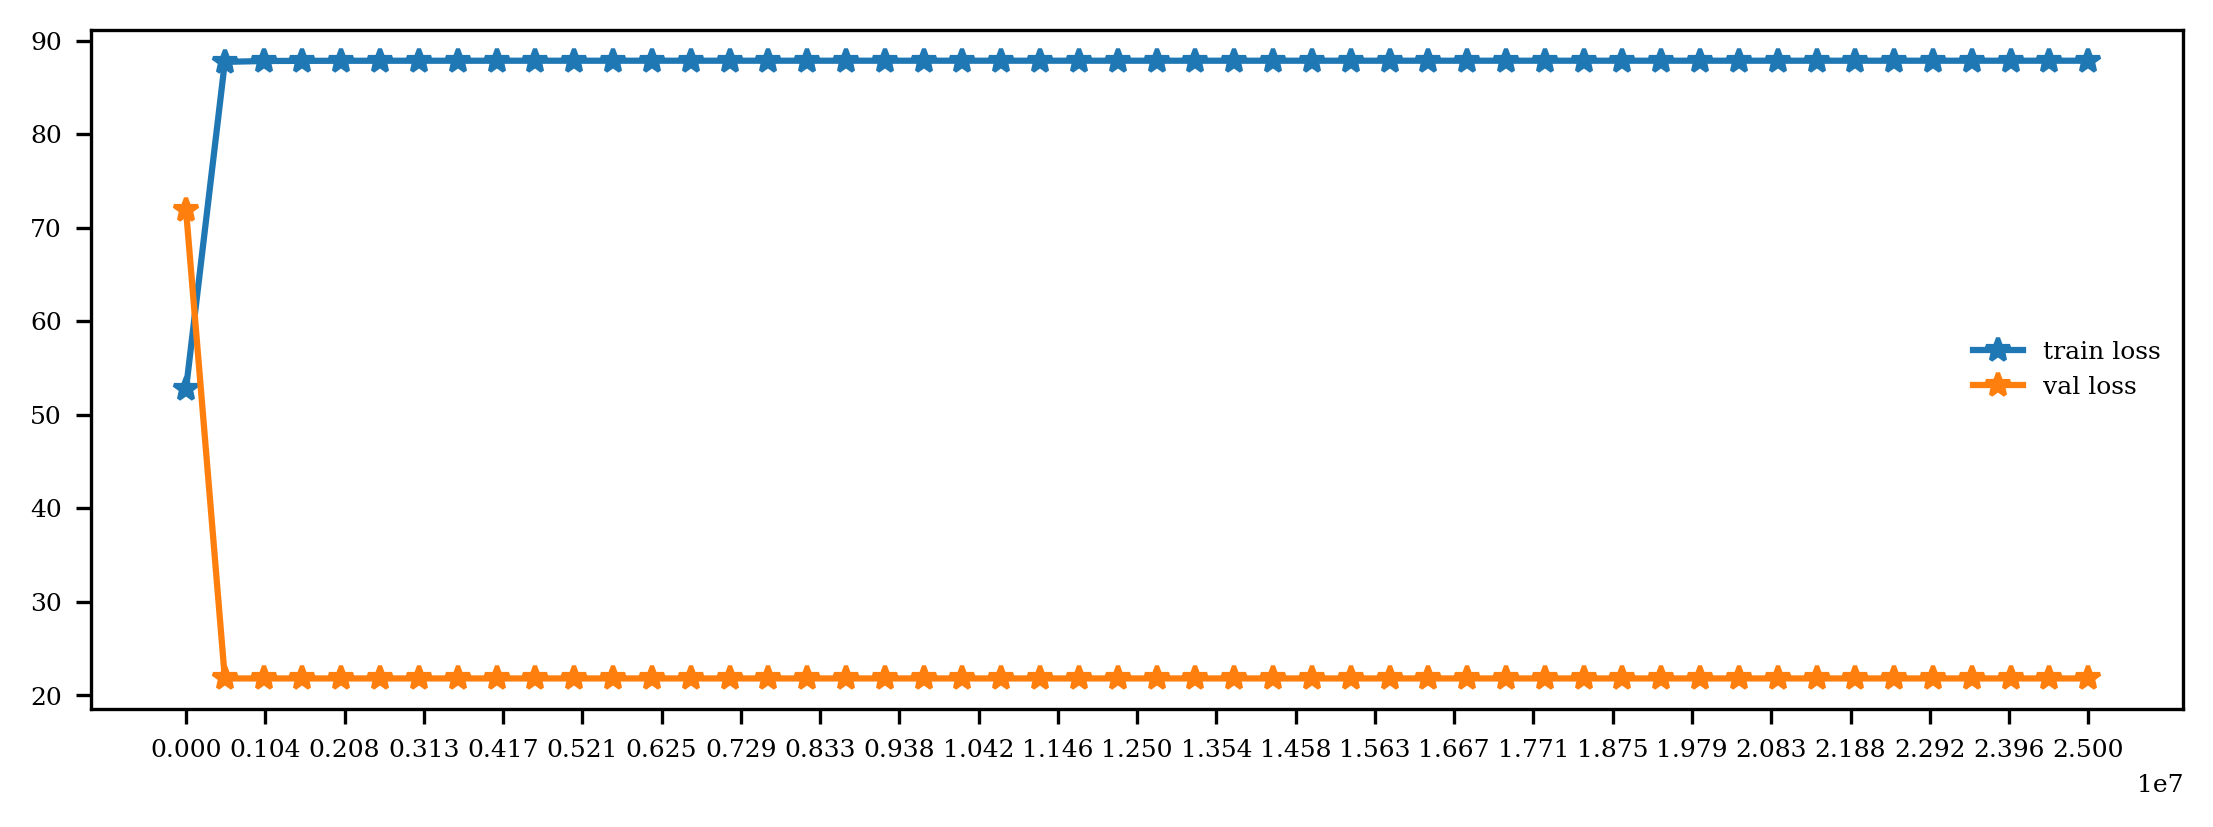

Min train. Train loss: 52.77211277473375, Val loss: 71.90657218958623. Regularizer: 1000.0
Min val. Train loss: 87.72871983807859, Val loss: 21.809129412890872. Regularizer: 511183.67346938775


In [41]:
losses_plot(regularizers, train_losses, val_losses)

2nd run

In [42]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(6e2, 1e3), r)

  0%|          | 0/50 [00:00<?, ?it/s]

Model form: cAHB
regularizer=600.0, integration error happens
Model form: cAHB
regularizer=608.1632653061224, integration error happens
Model form: cAHB
regularizer=616.3265306122449, integration error happens
Model form: cAHB
regularizer=624.4897959183673, integration error happens
Model form: cAHB
regularizer=632.6530612244898, integration error happens
Model form: cAHB
regularizer=640.8163265306123, integration error happens
Model form: cAHB
648.9795918367347 219.41970193154575 71.8331927312695
Model form: cAHB
657.1428571428571 186.88883148686878 71.95502859189817
Model form: cAHB
665.3061224489796 171.68205090904414 72.06713192893677
Model form: cAHB
673.469387755102 160.998437243101 72.17003691214082
Model form: cAHB
681.6326530612245 153.48923442421506 72.2642851459011
Model form: cAHB
689.795918367347 148.26494604114012 72.35062820686228
Model form: cAHB
697.9591836734694 144.6865982052456 72.42936615202944
Model form: cAHB
706.1224489795918 142.38964992925867 72.50106402584666

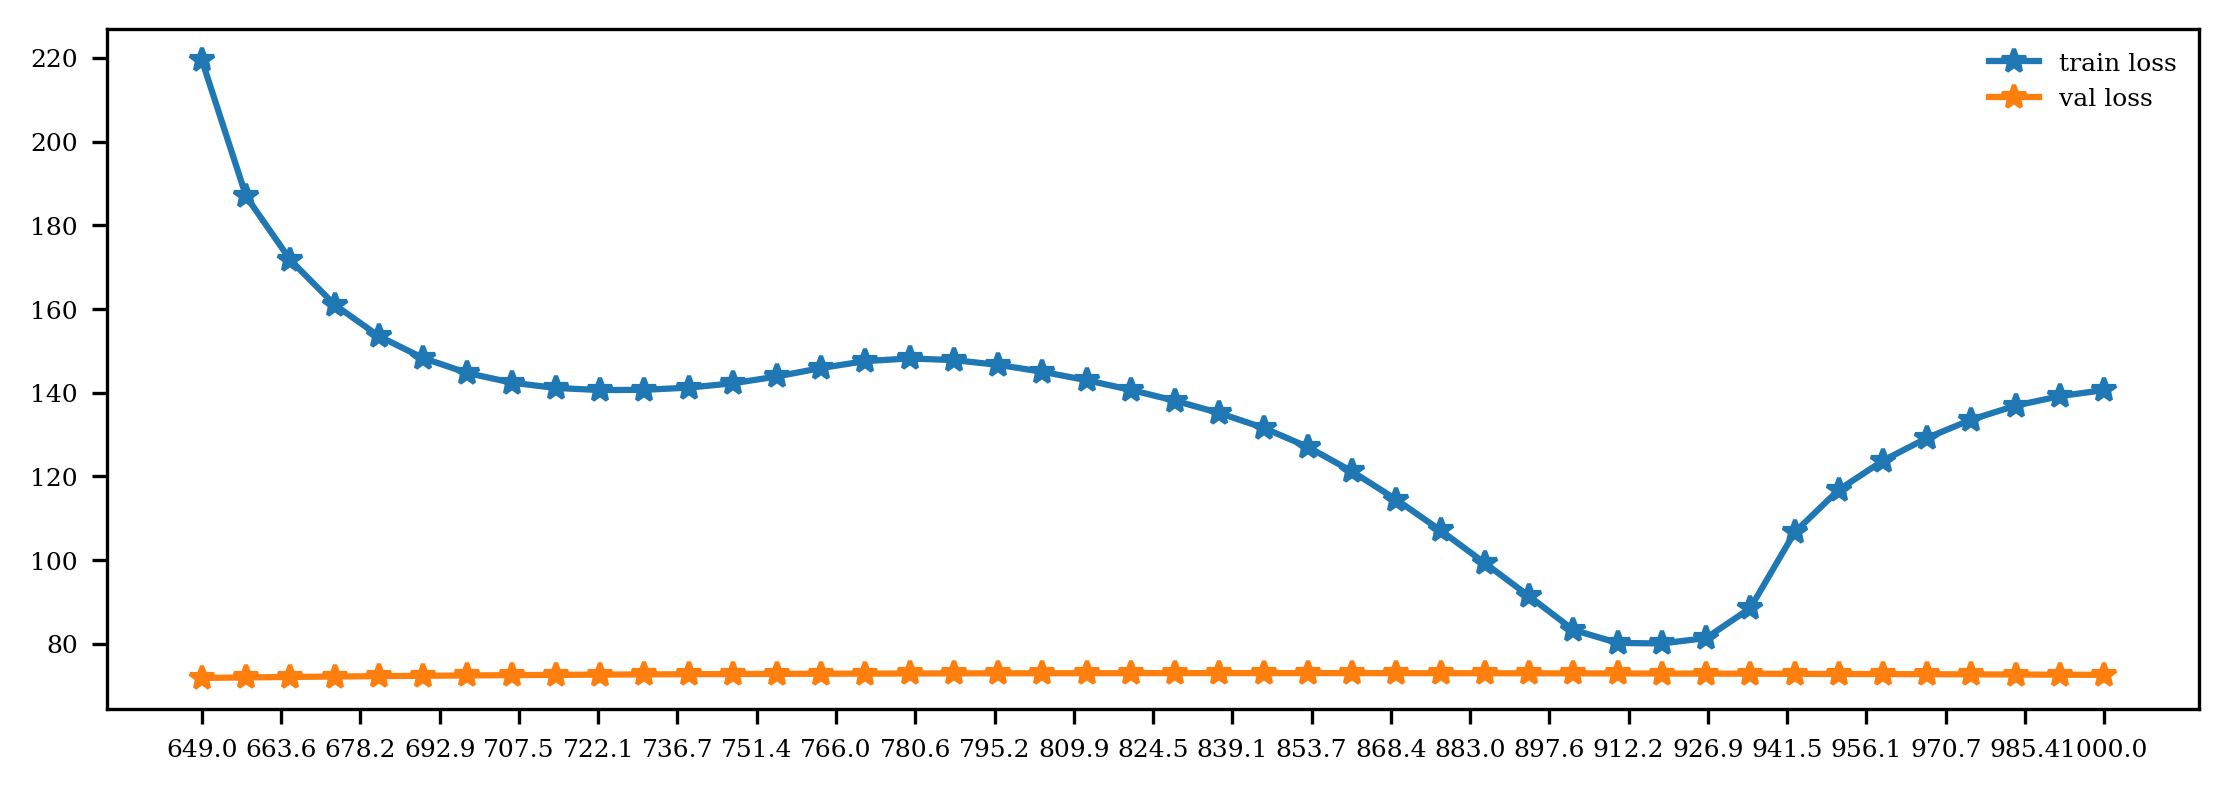

Min train. Train loss: 80.07083330109923, Val loss: 72.88830499581941. Regularizer: 918.3673469387755
Min val. Train loss: 219.41970193154575, Val loss: 71.8331927312695. Regularizer: 648.9795918367347


In [43]:
losses_plot(regularizers, train_losses, val_losses)

In [44]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(5e5, 6e5), r)

  0%|          | 0/50 [00:00<?, ?it/s]

Model form: cAHB
500000.0 87.79262931774538 21.84000307048101
Model form: cAHB
502040.8163265306 87.79370573838588 21.840001173807227
Model form: cAHB
504081.63265306124 87.7947688083691 21.839999345052075
Model form: cAHB
506122.44897959183 87.79581874814936 21.839997582250184
Model form: cAHB
508163.2653061224 87.7968557736432 21.83999588349587
Model form: cAHB
510204.0816326531 87.79788009634132 21.839994246940464
Model form: cAHB
512244.89795918367 87.7988919234168 21.839992670791364
Model form: cAHB
514285.71428571426 87.79989145783051 21.83999115330988
Model form: cAHB
516326.5306122449 87.80087889843605 21.839989692809425
Model form: cAHB
518367.3469387755 87.80185444009194 21.839988287653842
Model form: cAHB
520408.16326530615 87.80281827370453 21.839986936255738
Model form: cAHB
522448.97959183675 87.80377058638128 21.83998563707494
Model form: cAHB
524489.7959183673 87.80471156150129 21.839984388616934
Model form: cAHB
526530.612244898 87.80564137880418 21.839983189431397
Mod

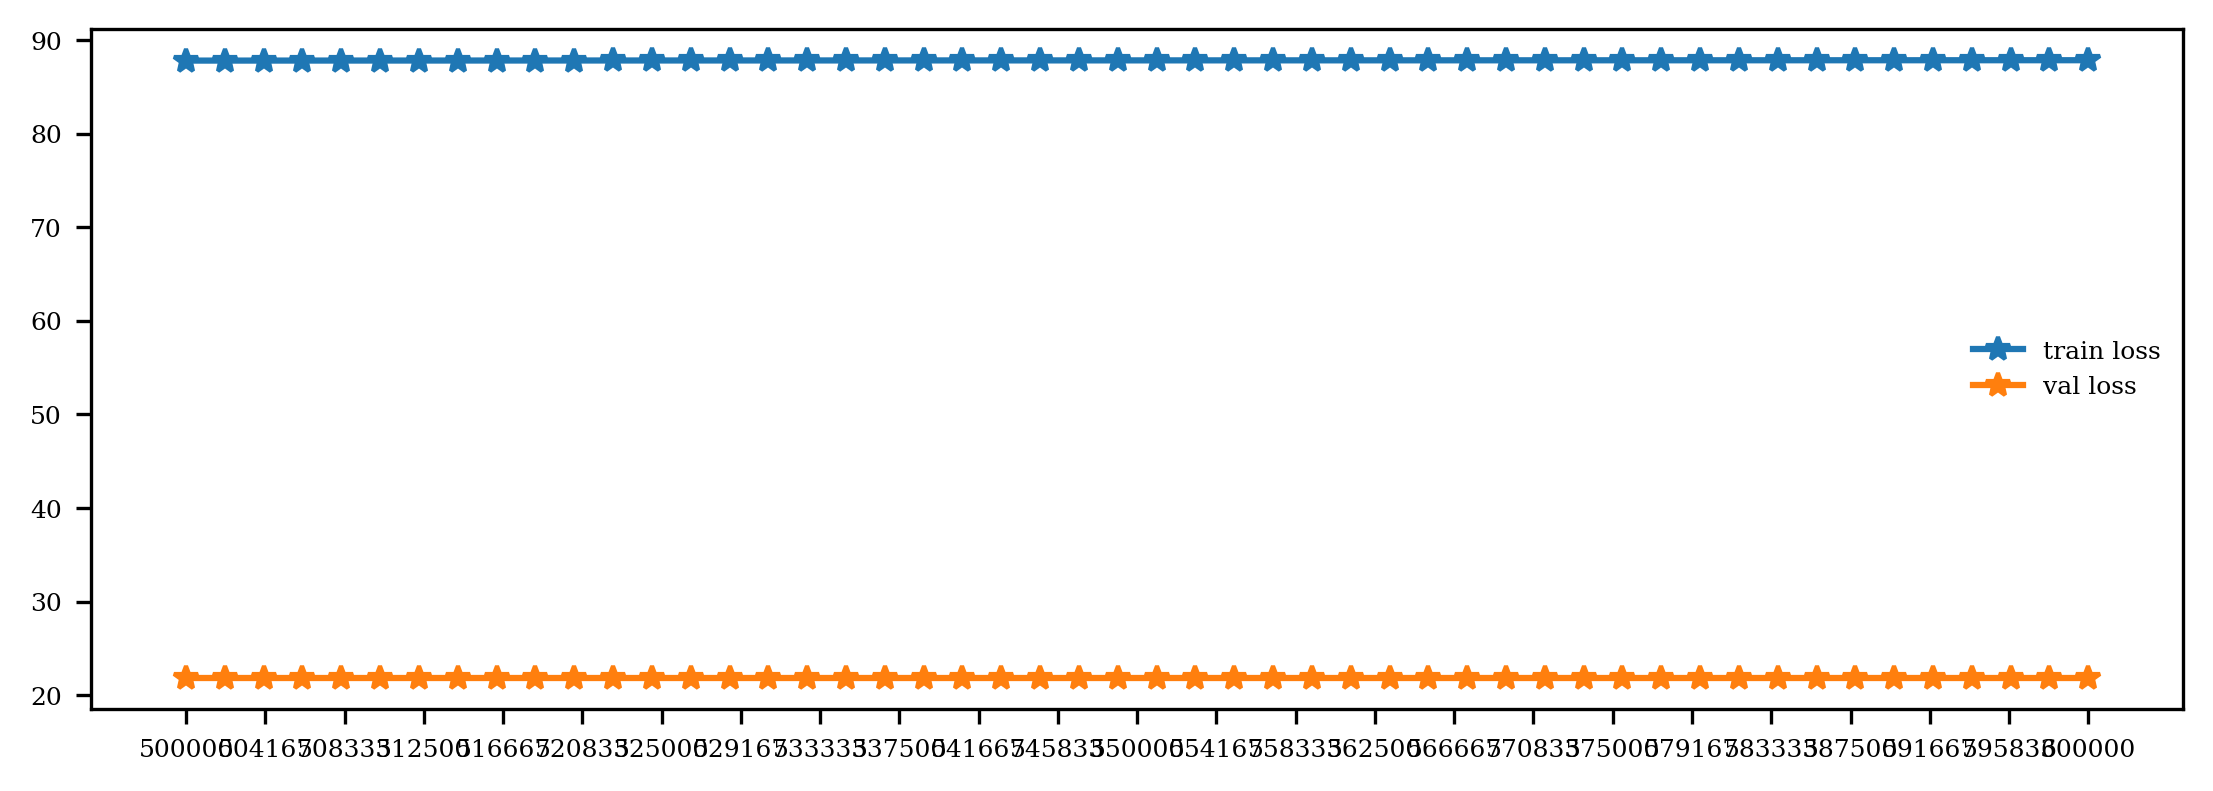

Min train. Train loss: 87.79262931774538, Val loss: 21.84000307048101. Regularizer: 500000.0
Min val. Train loss: 87.83294953725635, Val loss: 21.839963462346358. Regularizer: 600000.0


In [45]:
losses_plot(regularizers, train_losses, val_losses)

In [46]:
def plot_pred(groundtruth, prediction):
    plt.plot(range(groundtruth.shape[1]), groundtruth.mean(0))
    plt.plot(range(groundtruth.shape[1]), prediction.mean(0), alpha=0.5)
    plt.legend(["groundtruth", "prediction"])

## Plotting again with best params

In [47]:
assert 2==1

AssertionError: 

In [48]:
best_regularizer = 918.3673469387755

In [49]:
rom = prepare_data_and_train(train_data, r=r, regularizer=best_regularizer)
prediction = rom.predict(train_data[:,-1], np.arange(start_prediction, end_prediction, DELTA_T), 
                         input_func=inlet_function[train_data.shape[1]:train_data.shape[1]+tables['val_p'].shape[1]], 
                         method='Radau')   # predict from the last column of train data        
predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
sanity_check = rom.predict(train_data[:,0], np.arange(DELTA_T, start_prediction-DELTA_T, DELTA_T),
                          input_func=inlet_function[:train_data.shape[1]])
sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])

Model form: cAHB


In [50]:
mse(sanity_check , tables['train_p'], squared=False), mse(tables['val_p'], predicted_p, squared=False)

(80.04625150678096, 72.88830499581941)

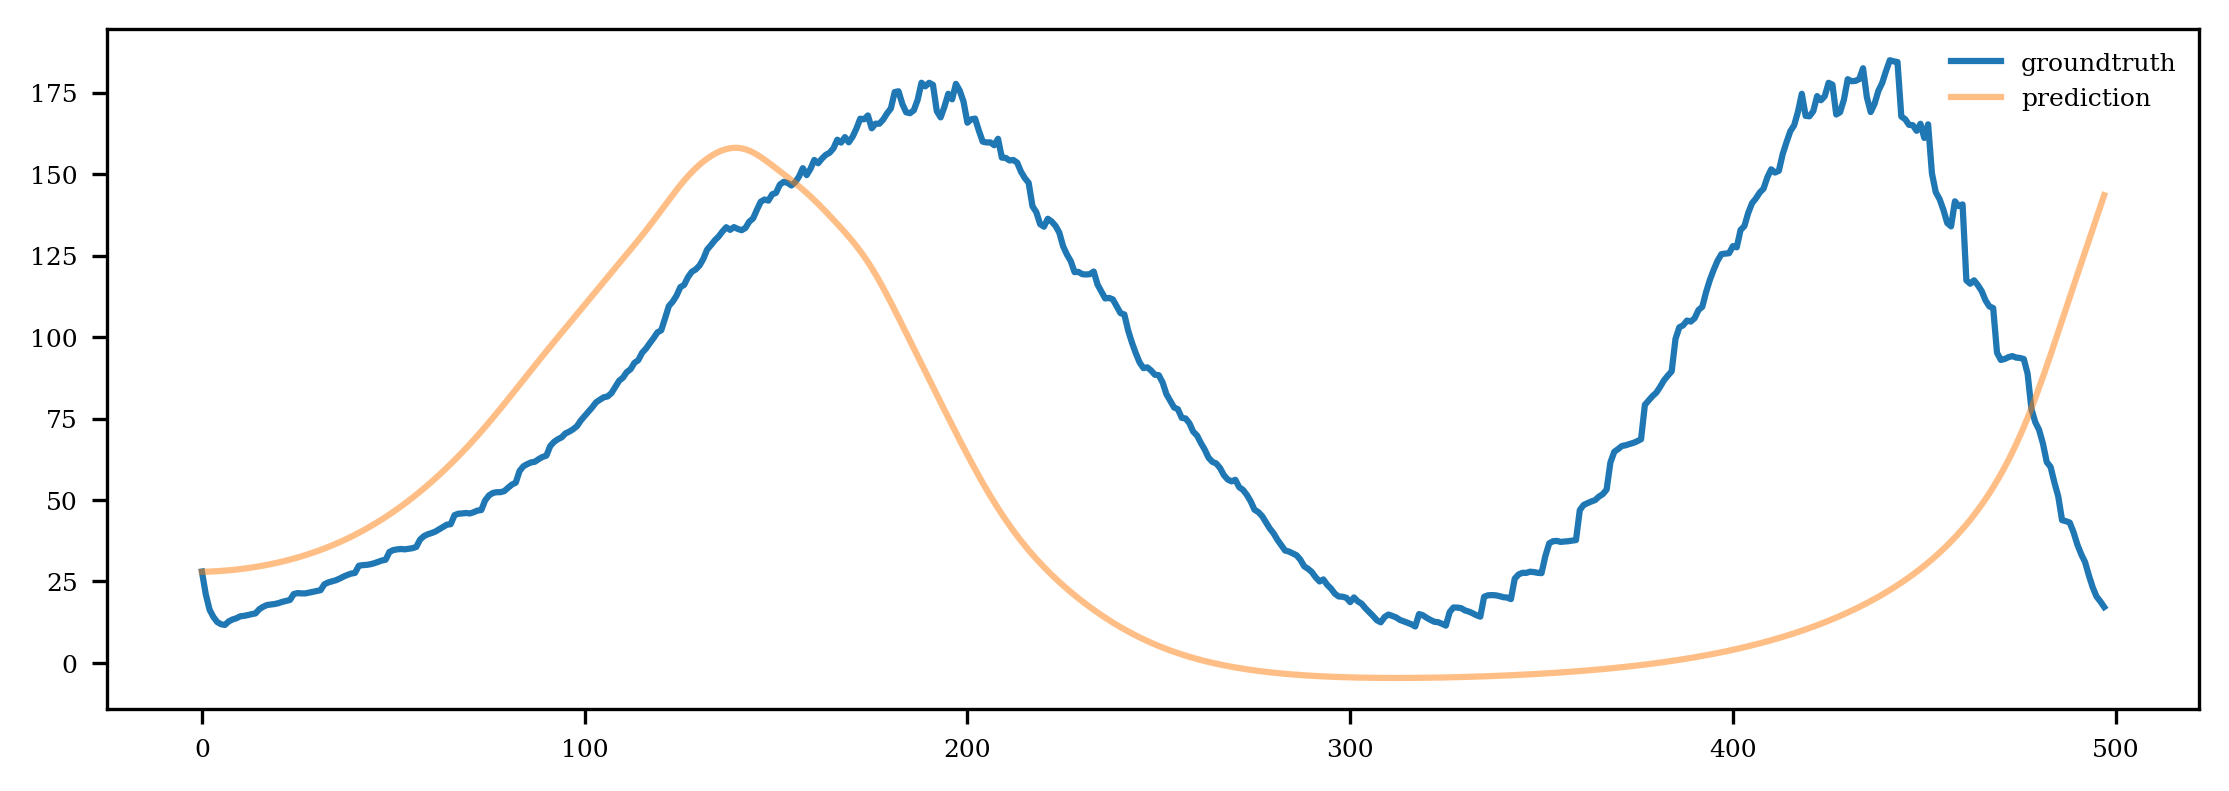

In [51]:
plot_pred(tables['train_p'], sanity_check)

## Train on train, val, and predict test

In [52]:
# Stack train, val and normalize
# concat train set with val set
train_data_dict = {}
for column in chosen_columns:
    train_data_dict[f'train_val_{column}'] = np.concatenate((tables[f'train_{column}'], tables[f'val_{column}']), axis=1)

In [53]:
# normalize each features 
normed_data, max_ft, min_ft = {}, {}, {}
for key in train_data_dict:
    if key.startswith('train_val_'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(train_data_dict[key])

In [54]:
# stack data
train_data = stack_data(normed_data, 'train_val')

After stacking shape:  (15164, 597)


In [55]:
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_val_{column}'][0]).all()

In [56]:
# train 
rom = prepare_data_and_train(train_data, r, regularizer=best_regularizer)
prediction_range = np.arange(end_prediction, 2, DELTA_T)
# predict
prediction = rom.predict(train_data[:,-1], prediction_range, 
                         input_func=inlet_function[-len(prediction_range):],
                         method='Radau')   # predict from the last column of val data
predicted_p = post_process(prediction, max_ft['train_val_p'], min_ft['train_val_p'])

tmp = mse(predicted_p, tables['test_p'], squared=False)
tmp

Model form: cAHB


34.77367125907225

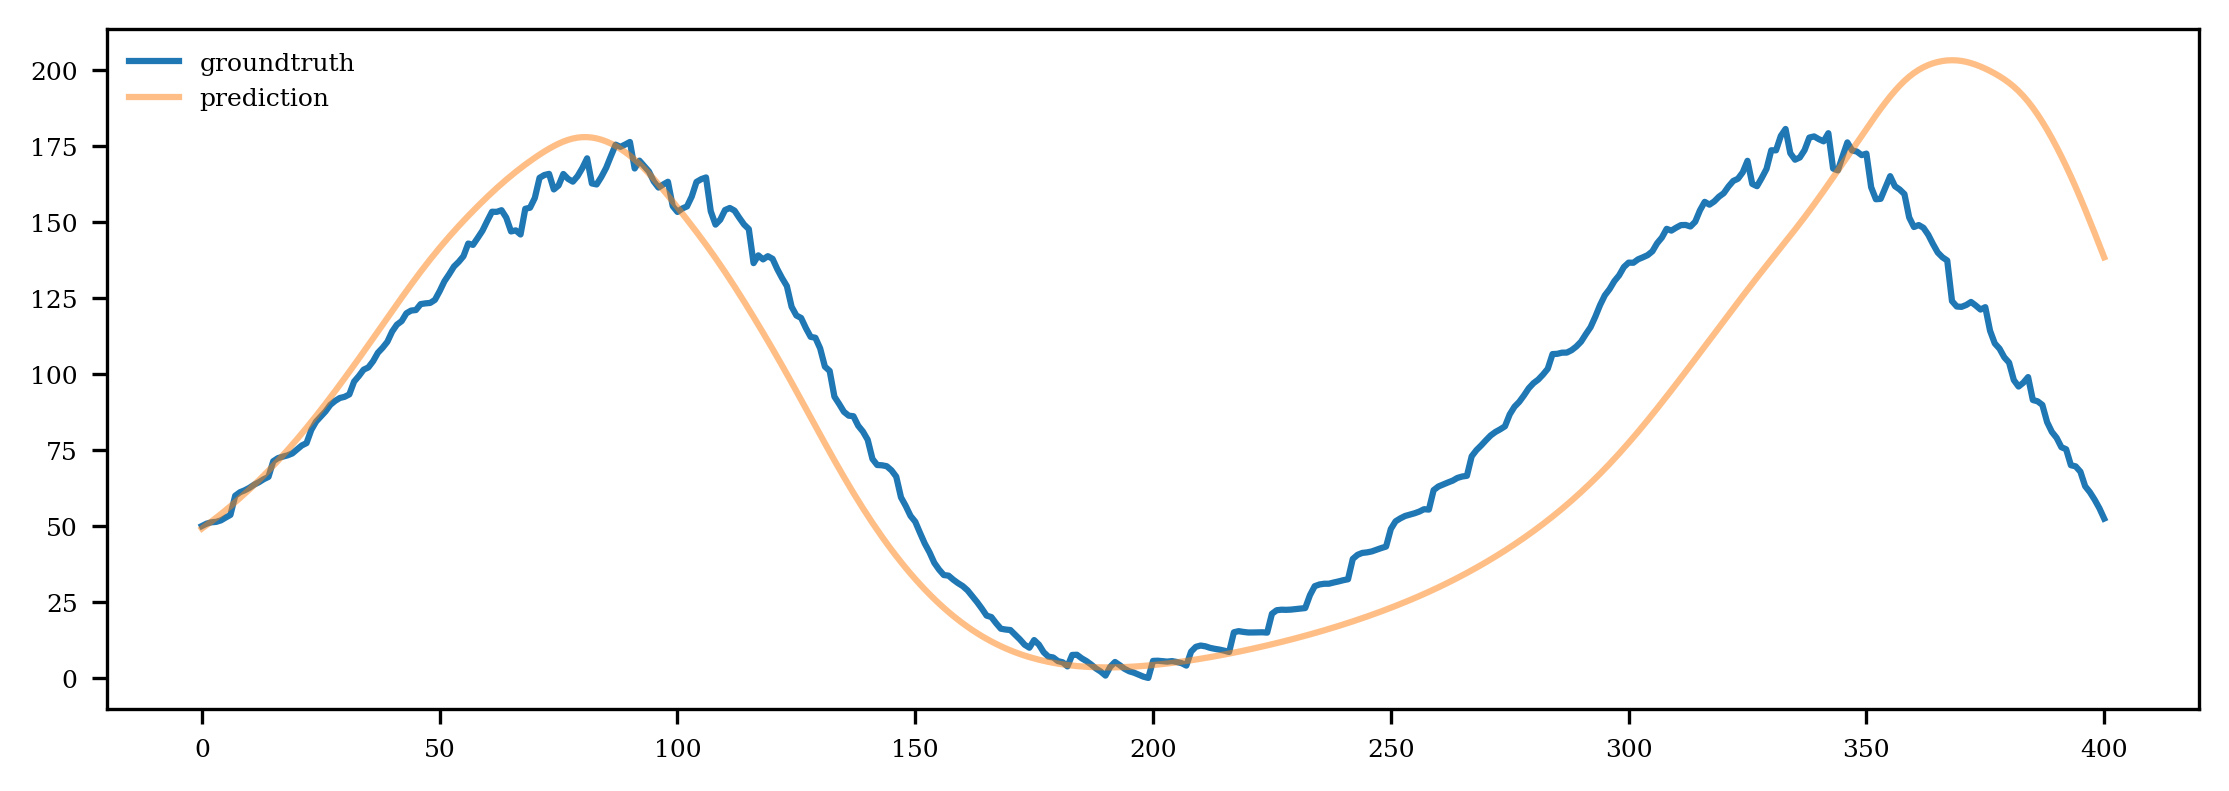

In [57]:
plot_pred(tables['test_p'], predicted_p)

In [58]:
chosen_columns

['p', 'U:2']